In [8]:
import re
from datetime import date

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy
from matplotlib.patches import Polygon
import pytrap
import geoip2.database
from pyasn import pyasn

In [10]:
%ls *.trapcap

linuxdays.trapcap  linuxdays2023.trapcap


In [12]:
df = pytrap.read_nemea("f:linuxdays.trapcap")

In [13]:
def plot_snis_stats(df, field):
    df = df[df[field] != ""]
    print(f'Total flows: {len(df)}')
    print(f'Unique SNIs: {len(df[field].unique())}')

    data = df[field].value_counts(normalize=True)[:11]

    _, ax = plt.subplots(figsize=(10, 8))

    ax = sns.barplot(y=data.index, x=data.values*100)

    ax.axes.set_title("Most common " + field, pad=20)
    ax.set_xlabel("Percentage", labelpad=10)
    ax.set_ylabel(field, labelpad=10)
    ax.tick_params(left=False, bottom=False)

    plt.show()


In [14]:
df.head()


,DST_IP,SRC_IP,BYTES,BYTES_REV,LINK_BIT_FIELD,TCP_OPT,TCP_OPT_REV,TIME_FIRST,TIME_LAST,DST_MAC,...,PROTOCOL,TCP_FLAGS,TCP_FLAGS_REV,DNS_NAME,DNS_RDATA,QUIC_SNI,QUIC_USER_AGENT,TLS_ALPN,TLS_JA3,TLS_SNI
0,162.142.125.243,147.32.77.59,72,0,1,0,0,1696765862.197,1696765862.197,d4:ad:71:6f:38:fe,...,1,0,0,,[],,,,[],
1,147.32.77.59,162.142.125.243,44,0,1,4,0,1696765862.197,1696765862.197,d4:3b:04:6d:31:2f,...,6,2,0,,[],,,,[],
2,ff02::fb,fe80::1c34:522c:a861:4f26,364,0,1,0,0,1696765863.844,1696765863.844,33:33:00:00:00:fb,...,17,0,0,,[],,,,[],
3,147.32.77.59,205.210.31.218,44,0,1,4,0,1696765864.285,1696765864.285,d4:3b:04:6d:31:2f,...,6,2,0,,[],,,,[],
4,147.32.77.59,165.154.172.159,60,0,1,286,0,1696765865.357,1696765865.357,d4:3b:04:6d:31:2f,...,6,2,0,,[],,,,[],


Total flows: 5
Unique SNIs: 5


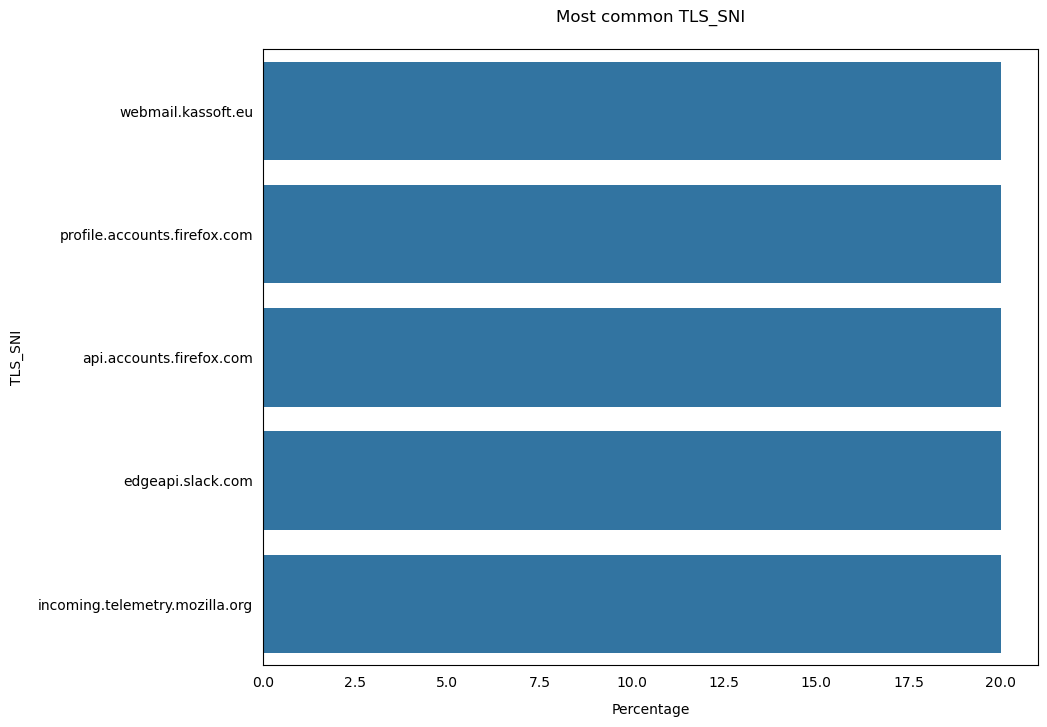

In [15]:
plot_snis_stats(df, "TLS_SNI")

Total flows: 0
Unique SNIs: 0


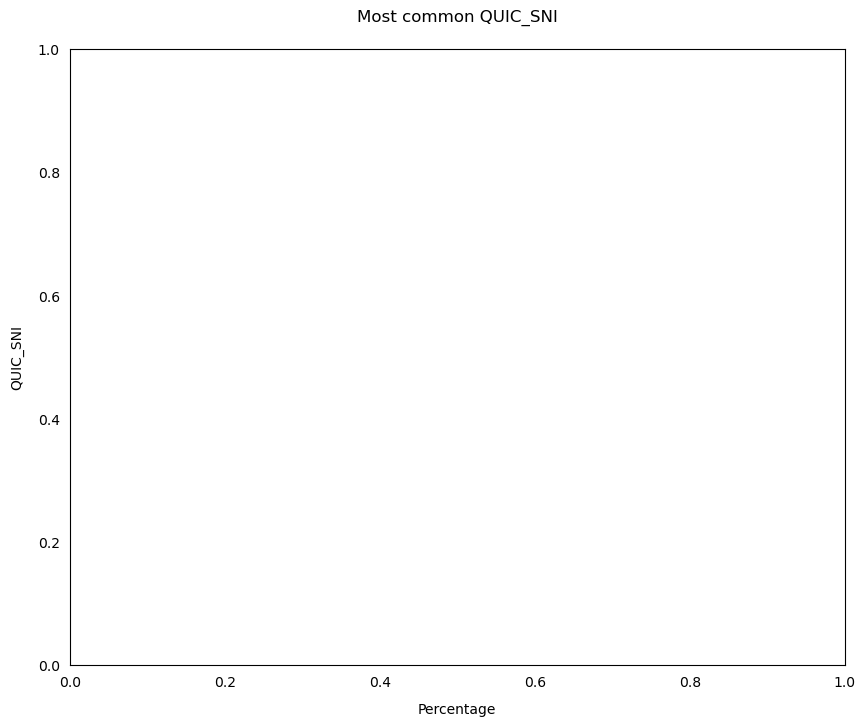

In [16]:
plot_snis_stats(df, "QUIC_SNI")

In [17]:
asndb = pyasn('./rib.20231008.1200.dat')

In [18]:
asns = df.DST_IP.apply(lambda x: asndb.lookup(str(x))[0])
asns = asns.dropna()
asns = asns.astype(int).astype(str)
asns

0      398324
1        2852
3        2852
4        2852
8        2852
        ...  
282      2852
283      2852
284      2852
286      2852
288     16509
Name: DST_IP, Length: 118, dtype: object

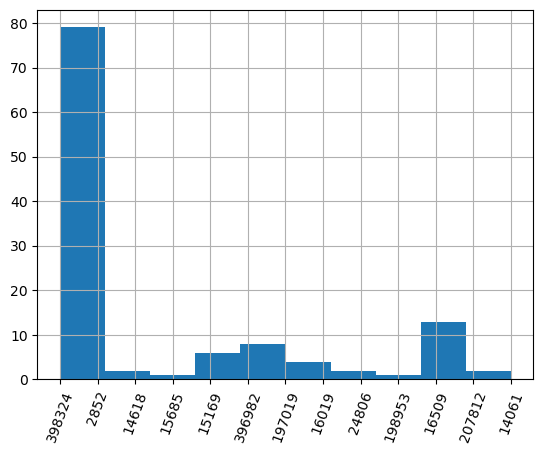

In [19]:
asns.hist()
plt.xticks(rotation=70)
plt.show()

86


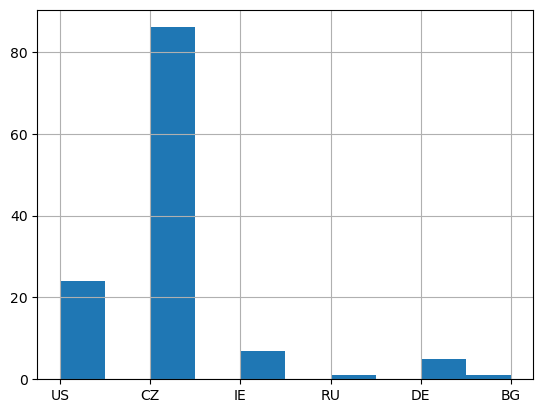

In [20]:
cntry_list = []
coords = {}
coords_cntry = {}
cntry_mass = {}
cntry_maxcount = 1
with geoip2.database.Reader('/usr/share/GeoIP/GeoLite2-City.mmdb') as reader:
    for row in df["DST_IP"]:
        try:
            response = reader.city(str(row))
            cntry_list.append(response.country.iso_code)
            c = (response.location.latitude, response.location.longitude)
            coords_cntry[c] = response.country.iso_code
            if response.country.iso_code not in cntry_mass:
                cntry_mass[response.country.iso_code] = 1
            else:
                cntry_mass[response.country.iso_code] += 1
                if cntry_maxcount < cntry_mass[response.country.iso_code]:
                    cntry_maxcount = cntry_mass[response.country.iso_code]
                
            if c not in coords:
                coords[c] = 1
            else:
                coords[c] += 1
                
        except:
            pass

pd.Series(cntry_list).hist()
print(cntry_maxcount)

In [21]:
df

,DST_IP,SRC_IP,BYTES,BYTES_REV,LINK_BIT_FIELD,TCP_OPT,TCP_OPT_REV,TIME_FIRST,TIME_LAST,DST_MAC,...,PROTOCOL,TCP_FLAGS,TCP_FLAGS_REV,DNS_NAME,DNS_RDATA,QUIC_SNI,QUIC_USER_AGENT,TLS_ALPN,TLS_JA3,TLS_SNI
0,162.142.125.243,147.32.77.59,72,0,1,0,0,1696765862.197,1696765862.197,d4:ad:71:6f:38:fe,...,1,0,0,,[],,,,[],
1,147.32.77.59,162.142.125.243,44,0,1,4,0,1696765862.197,1696765862.197,d4:3b:04:6d:31:2f,...,6,2,0,,[],,,,[],
2,ff02::fb,fe80::1c34:522c:a861:4f26,364,0,1,0,0,1696765863.844,1696765863.844,33:33:00:00:00:fb,...,17,0,0,,[],,,,[],
3,147.32.77.59,205.210.31.218,44,0,1,4,0,1696765864.285,1696765864.285,d4:3b:04:6d:31:2f,...,6,2,0,,[],,,,[],
4,147.32.77.59,165.154.172.159,60,0,1,286,0,1696765865.357,1696765865.357,d4:3b:04:6d:31:2f,...,6,2,0,,[],,,,[],
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,ff02::fb,fe80::1c21:2650:ab0b:f328,640,0,1,0,0,1696765965.581,1696765969.214,33:33:00:00:00:fb,...,17,0,0,,[],,,,[],
286,147.32.77.59,18.197.249.189,7006,2328,1,258,258,1696765860.279,1696765993.252,d4:3b:04:6d:31:2f,...,6,24,24,,[],,,,[],
287,255.255.255.255,147.32.77.29,2562,0,1,0,0,1696765861.055,1696765990.404,ff:ff:ff:ff:ff:ff,...,17,0,0,,[],,,,[],
288,18.197.249.189,147.32.77.59,2236,3338,1,258,258,1696765860.208,1696765992.456,d4:ad:71:6f:38:fe,...,6,24,24,,[],,,,[],


<Axes: ylabel='PROTOCOL'>

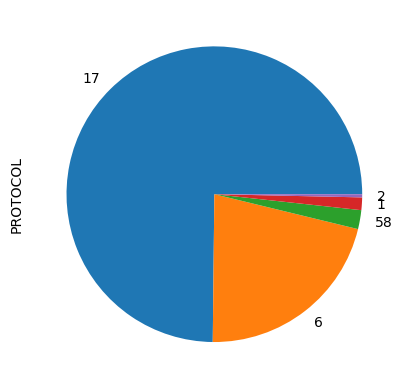

In [22]:
df.PROTOCOL.value_counts().plot.pie()

In [23]:
df[df.DST_PORT==443]

,DST_IP,SRC_IP,BYTES,BYTES_REV,LINK_BIT_FIELD,TCP_OPT,TCP_OPT_REV,TIME_FIRST,TIME_LAST,DST_MAC,...,PROTOCOL,TCP_FLAGS,TCP_FLAGS_REV,DNS_NAME,DNS_RDATA,QUIC_SNI,QUIC_USER_AGENT,TLS_ALPN,TLS_JA3,TLS_SNI
23,18.213.32.120,147.32.77.59,52,0,1,258,0,1696765882.363,1696765882.363,d4:ad:71:6f:38:fe,...,6,16,0,,[],,,,[],
24,2a00:1450:4014:80e::200e,2001:718:2:2905:f26a:d8f2:bd89:cbd6,6417,6784,1,258,258,1696765882.072,1696765882.345,d4:ad:71:6f:38:fe,...,6,24,24,,[],,,,[],
32,142.251.36.142,147.32.77.59,91,91,1,258,258,1696765887.981,1696765888.294,d4:ad:71:6f:38:fe,...,6,24,24,,[],,,,[],
34,34.110.207.168,147.32.77.59,1346,1097,1,286,286,1696765890.129,1696765890.160,d4:ad:71:6f:38:fe,...,6,26,26,,[],,,,"[194, 121, 176, 24, 158, 219, 146, 105, 218, 1...",profile.accounts.firefox.com
37,34.110.207.168,147.32.77.59,1060,335,1,258,258,1696765875.938,1696765890.320,d4:ad:71:6f:38:fe,...,6,24,24,,[],,,,[],
38,34.117.14.220,147.32.77.59,2687,5185,1,286,286,1696765890.139,1696765891.266,d4:ad:71:6f:38:fe,...,6,26,26,,[],,,,"[194, 121, 176, 24, 158, 219, 146, 105, 218, 1...",api.accounts.firefox.com
48,192.168.1.230,147.32.77.59,300,0,1,286,0,1696765881.534,1696765896.698,d4:ad:71:6f:38:fe,...,6,2,0,,[],,,,[],
85,35.186.227.140,147.32.77.59,490848,25128,1,258,258,1696765870.077,1696765906.318,d4:ad:71:6f:38:fe,...,6,24,24,,[],,,,[],
89,2a00:1450:4014:80e::200a,2001:718:2:2905:f26a:d8f2:bd89:cbd6,111,144,1,258,258,1696765908.955,1696765909.003,d4:ad:71:6f:38:fe,...,6,24,17,,[],,,,[],
105,2a00:1450:4014:80b::200e,2001:718:2:2905:f26a:d8f2:bd89:cbd6,2440,1038,1,258,258,1696765909.954,1696765913.689,d4:ad:71:6f:38:fe,...,6,24,24,,[],,,,[],


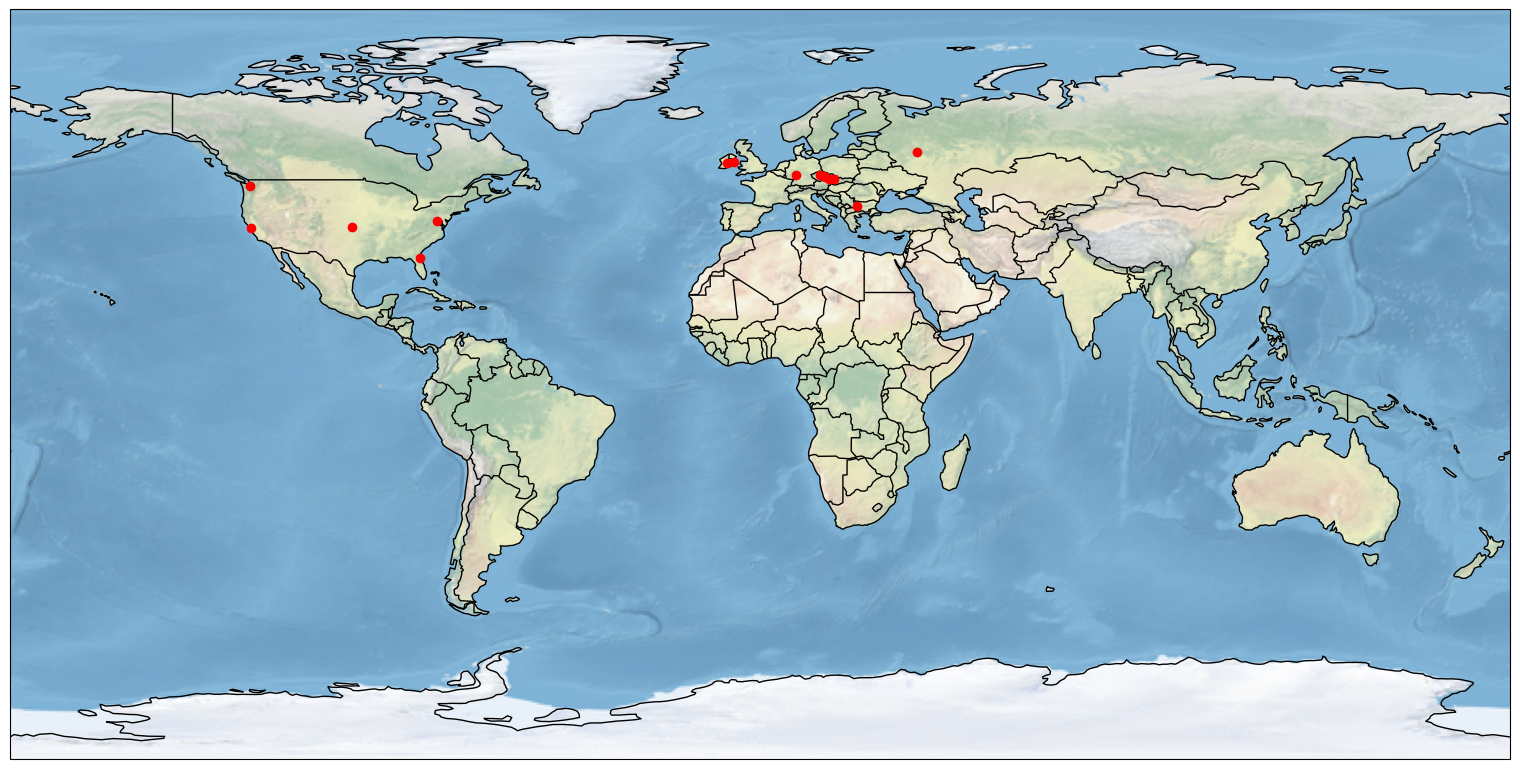

In [24]:
plt.figure(figsize=(15, 15))
ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS)
ax.stock_img()

for k in coords:
    plt.plot(k[1], k[0], color='red', linewidth=10*coords[k]/cntry_maxcount, marker='o',
         transform=ccrs.Geodetic(),)

plt.show()

US United States 27.906976744186046
RU Russian Federation 1.1627906976744187
DE Germany 5.813953488372093
BG Bulgaria 1.1627906976744187
IE Ireland 8.13953488372093
CZ Czech Republic 100.0


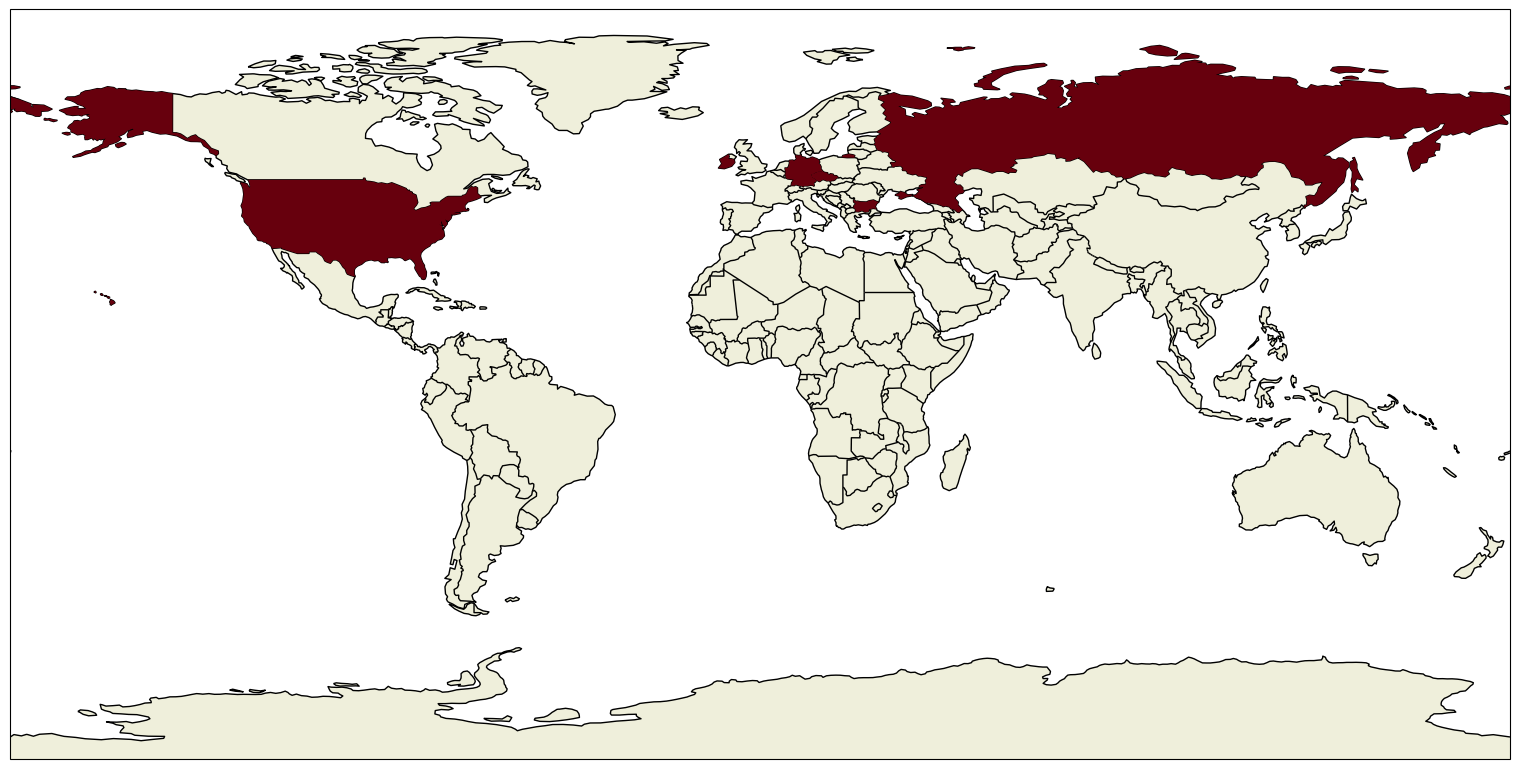

In [25]:
import cartopy.io.shapereader as shpreader
plt.figure(figsize=(15, 15))
ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS)
#ax.stock_img()

shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m',
                                        category='cultural', name=shapename)
colors = sns.color_palette("Reds", as_cmap=True)
colors
for country in shpreader.Reader(countries_shp).records():
    isoname = country.attributes["ISO_A2"]
    if isoname in cntry_mass:
        percent = 100 * cntry_mass[isoname] / float(cntry_maxcount)
        print(isoname, country.attributes['NAME_LONG'], percent)
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                      facecolor=colors(percent),
                      label=country.attributes['NAME_LONG'])
    

plt.show()